# `PyMC` - Data SAO 184555 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time

import scipy.special as sc
from scipy.interpolate import interp1d
from astropy import units as u
from skyfield.api import load
import pymc as pm
import arviz as az

import aesara
import aesara.tensor as at
from aesara.compile.ops import as_op

az.style.use("arviz-darkgrid")
# plt.style.use(['science', 'notebook'])
# plt.style.use(['science', 'notebook', 'grid'])
pd.set_option('display.float_format',  '{:}'.format)

In [2]:
df = pd.read_csv("sao184555.csv", sep=',')
df.head()

FrameNum            timeInfo  signal-obj  appsum-obj  avgbkg-obj  \
0    2501.0  [14:31:20.7269980]     59845.0   1192176.0    30603.53   
1    2502.0  [14:31:20.7470934]     45838.0   1177712.0    30591.18   
2    2503.0  [14:31:20.7671888]     54117.0   1184944.0    30562.89   
3    2504.0  [14:31:20.7872842]     74622.0   1209216.0     30664.7   
4    2505.0  [14:31:20.8073796]     49582.0   1181264.0    30585.99   

   stdbkg-obj  nmaskpx-obj  maxpx-obj  xcentroid-obj  ycentroid-obj  
0     1495.24          -37      38768          373.0          395.0  
1     1527.82          -37      38320          373.0          395.0  
2     1550.52          -37      37648          373.0          395.0  
3     1494.73          -37      43056          373.0          395.0  
4     1554.49          -37      41616          373.0          395.0

In [3]:
# hilangkan karakter [ dan ] dari data
df['timeInfo'] = df['timeInfo'].map((lambda x: x.lstrip('[').rstrip(']')))

# ubah ke format waktu dan ambil tanggal dan jamnya
df['timeInfo'] = pd.to_datetime(df['timeInfo'])

df.head()

FrameNum                   timeInfo  signal-obj  appsum-obj  avgbkg-obj  \
0    2501.0 2022-08-09 14:31:20.726998     59845.0   1192176.0    30603.53   
1    2502.0 2022-08-09 14:31:20.747093     45838.0   1177712.0    30591.18   
2    2503.0 2022-08-09 14:31:20.767188     54117.0   1184944.0    30562.89   
3    2504.0 2022-08-09 14:31:20.787284     74622.0   1209216.0     30664.7   
4    2505.0 2022-08-09 14:31:20.807379     49582.0   1181264.0    30585.99   

   stdbkg-obj  nmaskpx-obj  maxpx-obj  xcentroid-obj  ycentroid-obj  
0     1495.24          -37      38768          373.0          395.0  
1     1527.82          -37      38320          373.0          395.0  
2     1550.52          -37      37648          373.0          395.0  
3     1494.73          -37      43056          373.0          395.0  
4     1554.49          -37      41616          373.0          395.0

In [4]:
data = df[['FrameNum','timeInfo','signal-obj']]
data.columns = ['Frame','Date', 'Value']
data.head()

Frame                       Date   Value
0 2501.0 2022-08-09 14:31:20.726998 59845.0
1 2502.0 2022-08-09 14:31:20.747093 45838.0
2 2503.0 2022-08-09 14:31:20.767188 54117.0
3 2504.0 2022-08-09 14:31:20.787284 74622.0
4 2505.0 2022-08-09 14:31:20.807379 49582.0

In [5]:
data_cp = data.copy() # buat copy dari dataframe asli

data_cp['JD'] = Time(data_cp['Date']).jd

data_cp['frac_JD'] = data_cp['JD'] - np.floor(data_cp['JD']).astype(int)
data_cp

Frame                       Date   Value                 JD  \
0    2501.0 2022-08-09 14:31:20.726998 59845.0  2459801.105101007   
1    2502.0 2022-08-09 14:31:20.747093 45838.0 2459801.1051012394   
2    2503.0 2022-08-09 14:31:20.767188 54117.0  2459801.105101472   
3    2504.0 2022-08-09 14:31:20.787284 74622.0 2459801.1051017046   
4    2505.0 2022-08-09 14:31:20.807379 49582.0 2459801.1051019374   
...     ...                        ...     ...                ...   
1695 4196.0 2022-08-09 14:31:54.788427 -9983.0 2459801.1054952363   
1696 4197.0 2022-08-09 14:31:54.808522 -3012.0  2459801.105495469   
1697 4198.0 2022-08-09 14:31:54.828618  3204.0 2459801.1054957015   
1698 4199.0 2022-08-09 14:31:54.848713 13609.0 2459801.1054959344   
1699 4200.0 2022-08-09 14:31:54.868808  1965.0 2459801.1054961667   

                 frac_JD  
0    0.10510100703686476  
1    0.10510123940184712  
2    0.10510147223249078  
3    0.10510170459747314  
4     0.1051019374281168  
...                  ...  
1695 0.10549523634836078  
1696 0.10549546917900443  
1697  0.1054957015439868  
1698 0.10549593437463045  
1699 0.10549616673961282  

[1700 rows x 5 columns]

Text(0.5, 0, 'Frames')

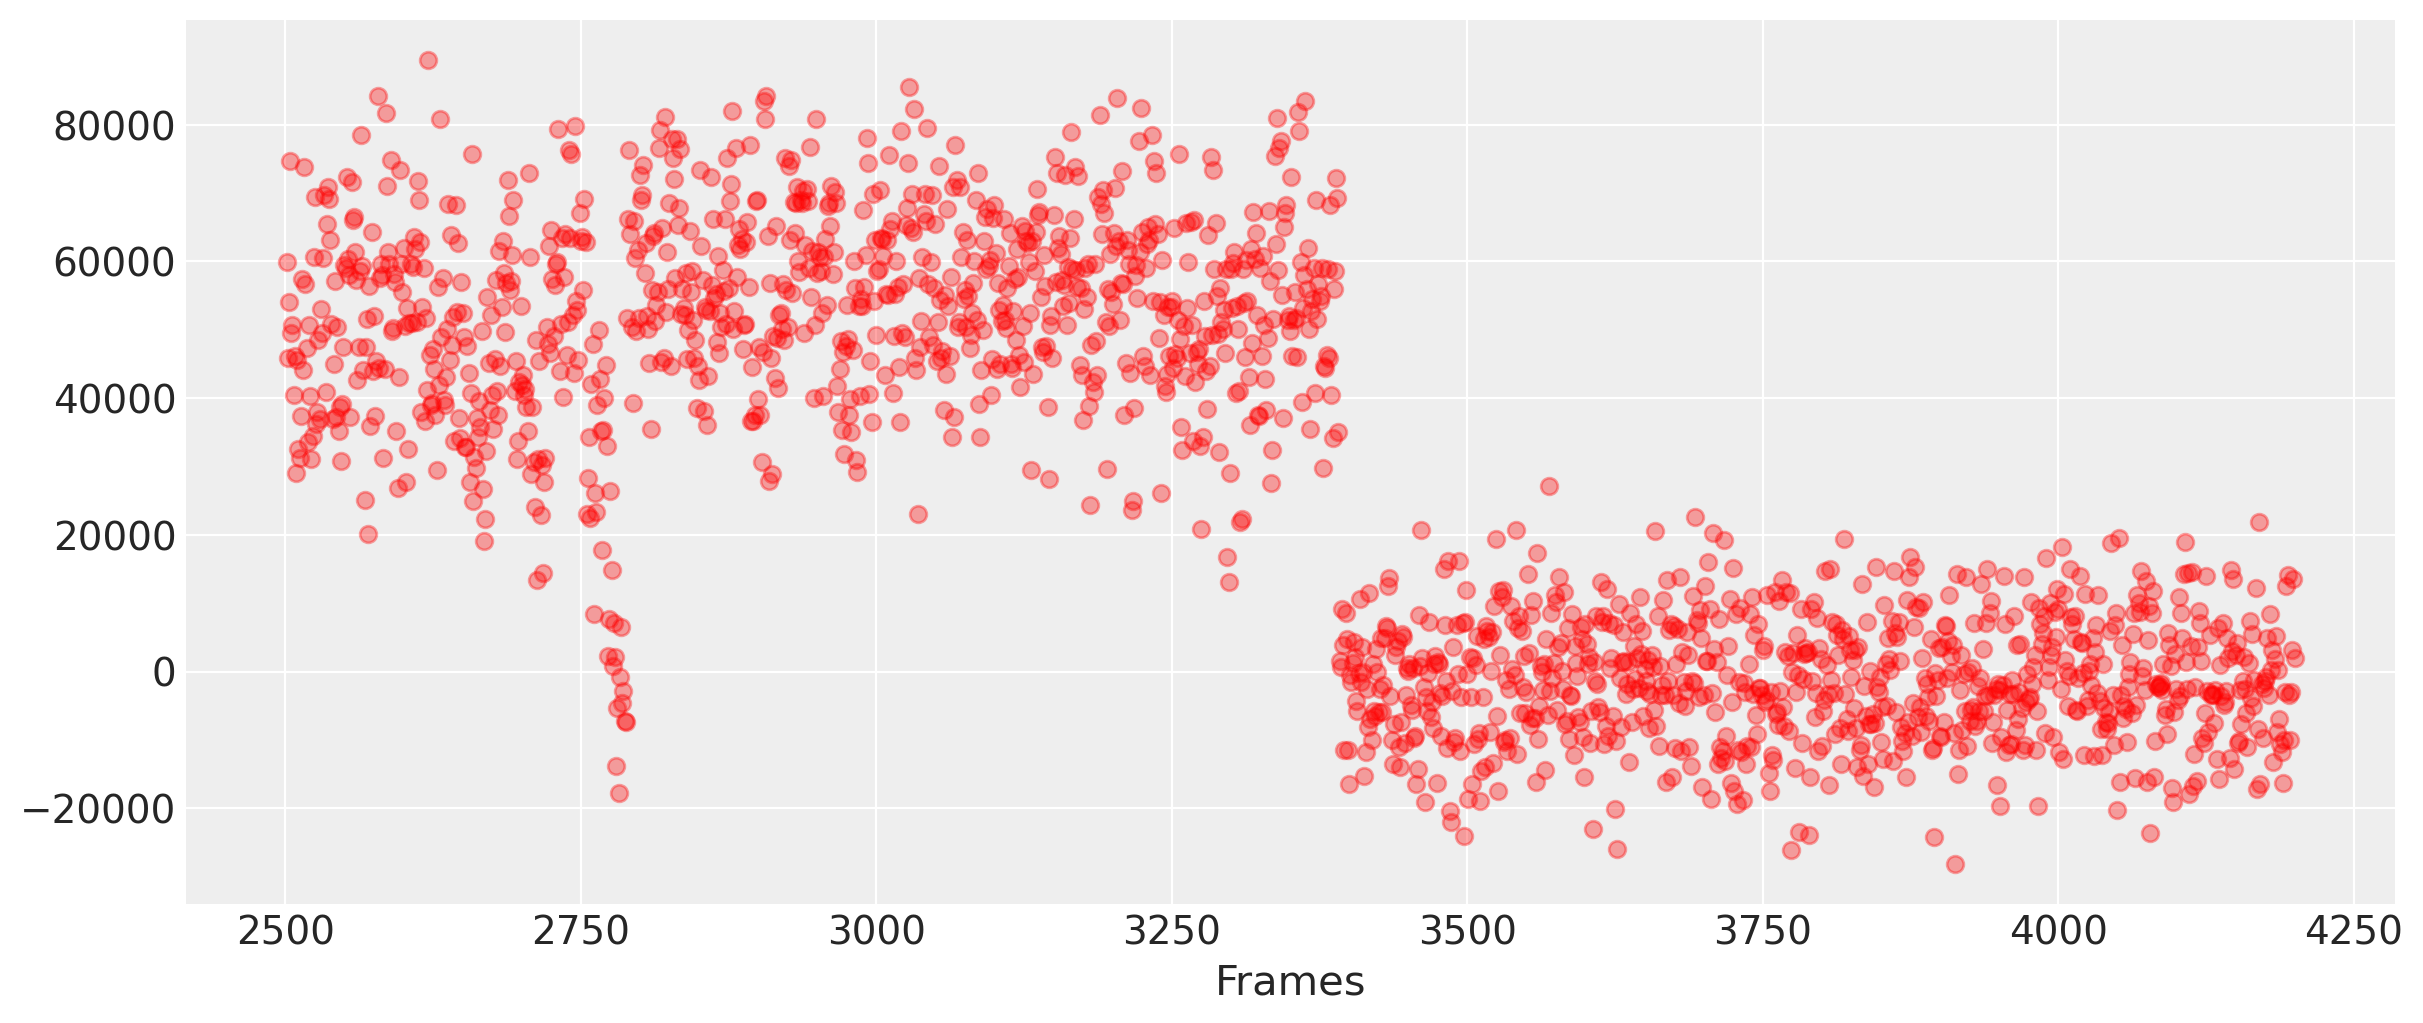

In [6]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(data_cp['Frame'], data_cp['Value'], 'ro', alpha=0.35)
# ax.set_xlim(3300, 3700)
ax.set_xlabel('Frames')

## Normalisasi

In [7]:
def Normalisasi(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) 

In [8]:
# value_scaled = Normalisasi(data['Value'])
value_scaled = data['Value']/(data['Value'].std()*2)

Text(0.5, 0, 'Frames')

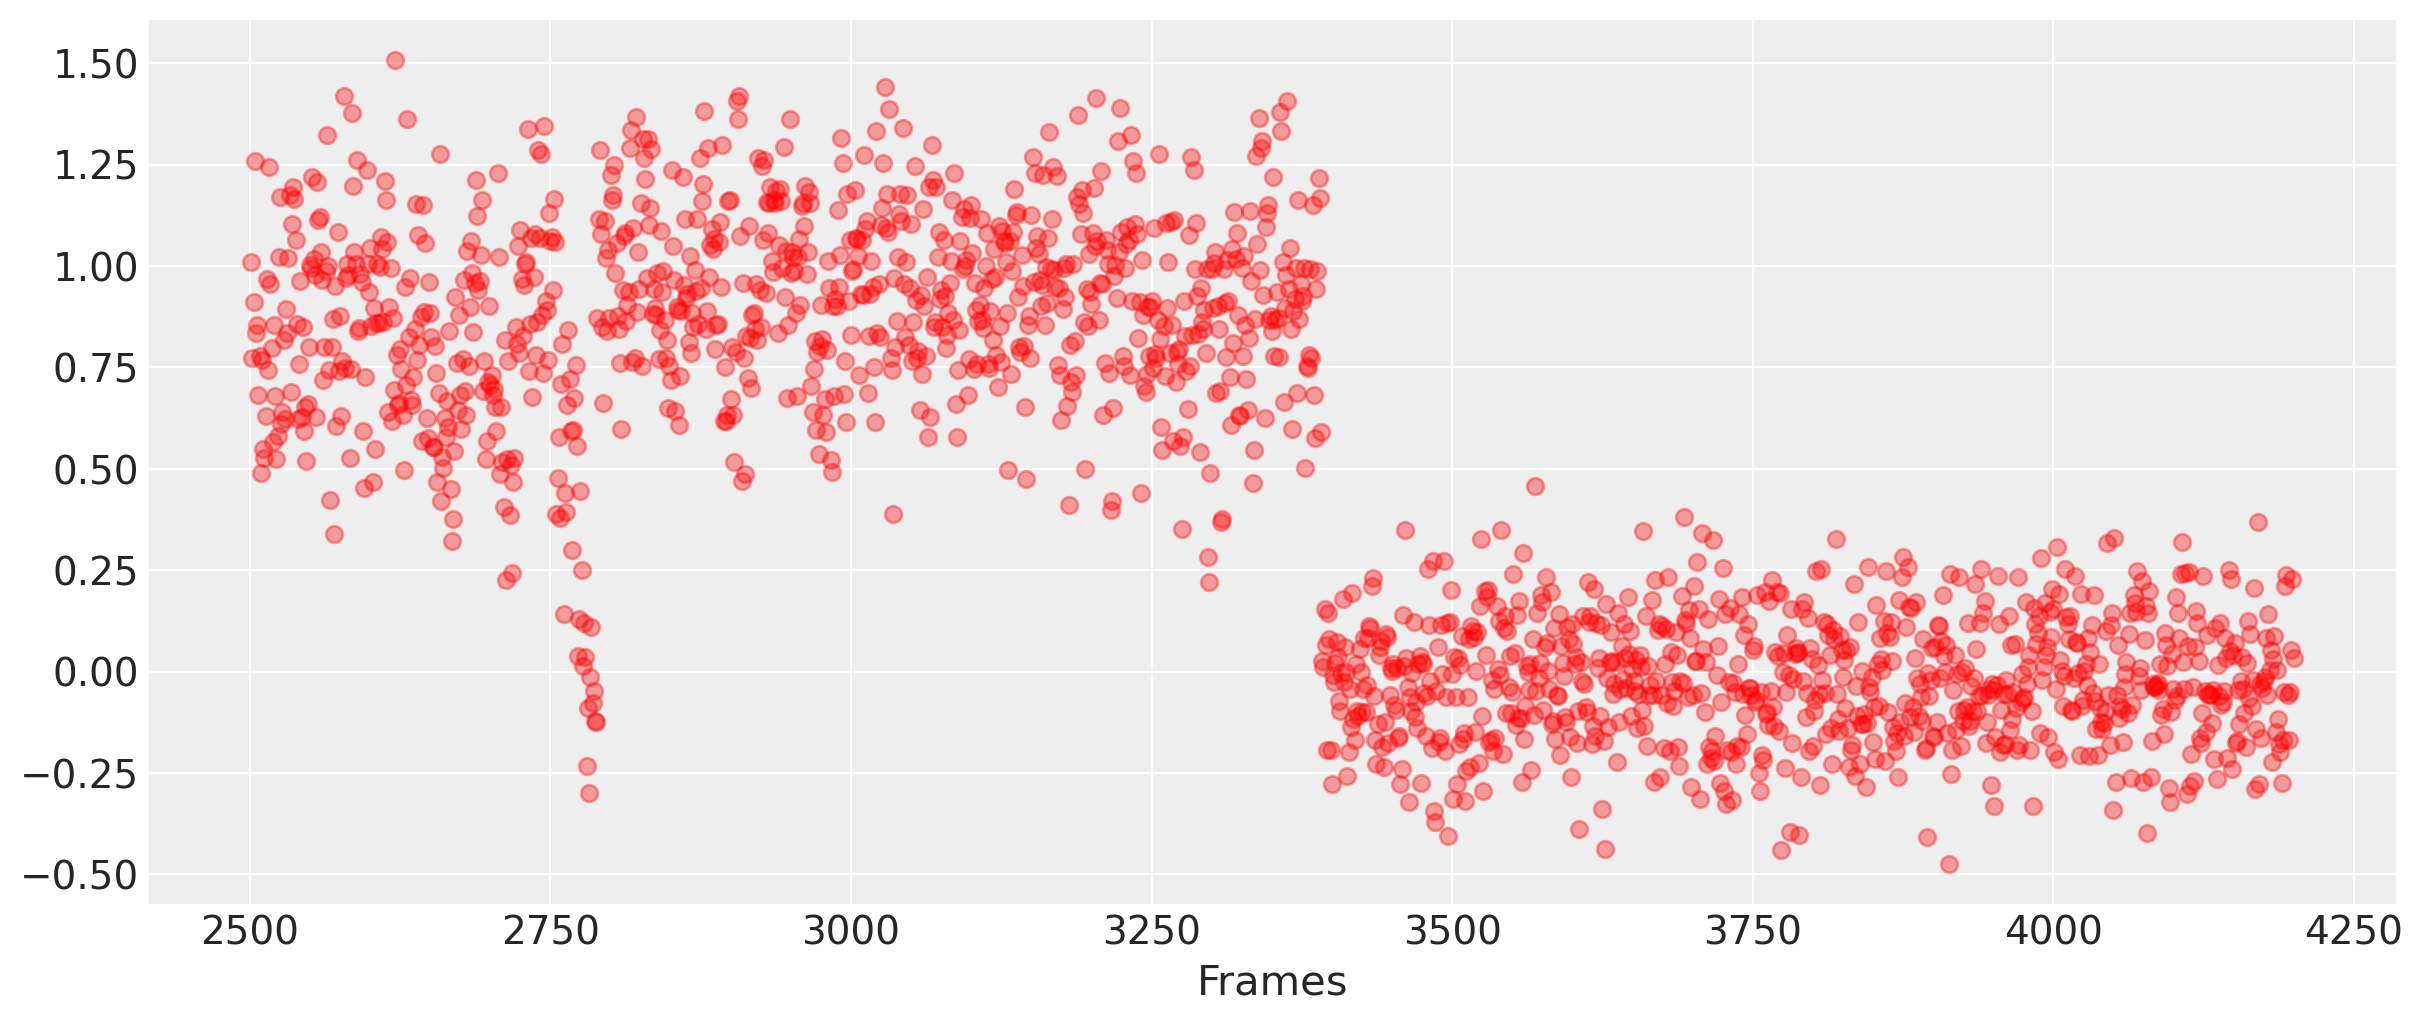

In [9]:
fig, ax = plt.subplots(figsize=(12,5))
# ax.plot(data['frac_JD'], value_scaled, 'ro', alpha=0.35)
ax.plot(data_cp['Frame'], value_scaled, 'ro', alpha=0.35)
ax.set_xlabel('Frames')

(3000.0, 3750.0)

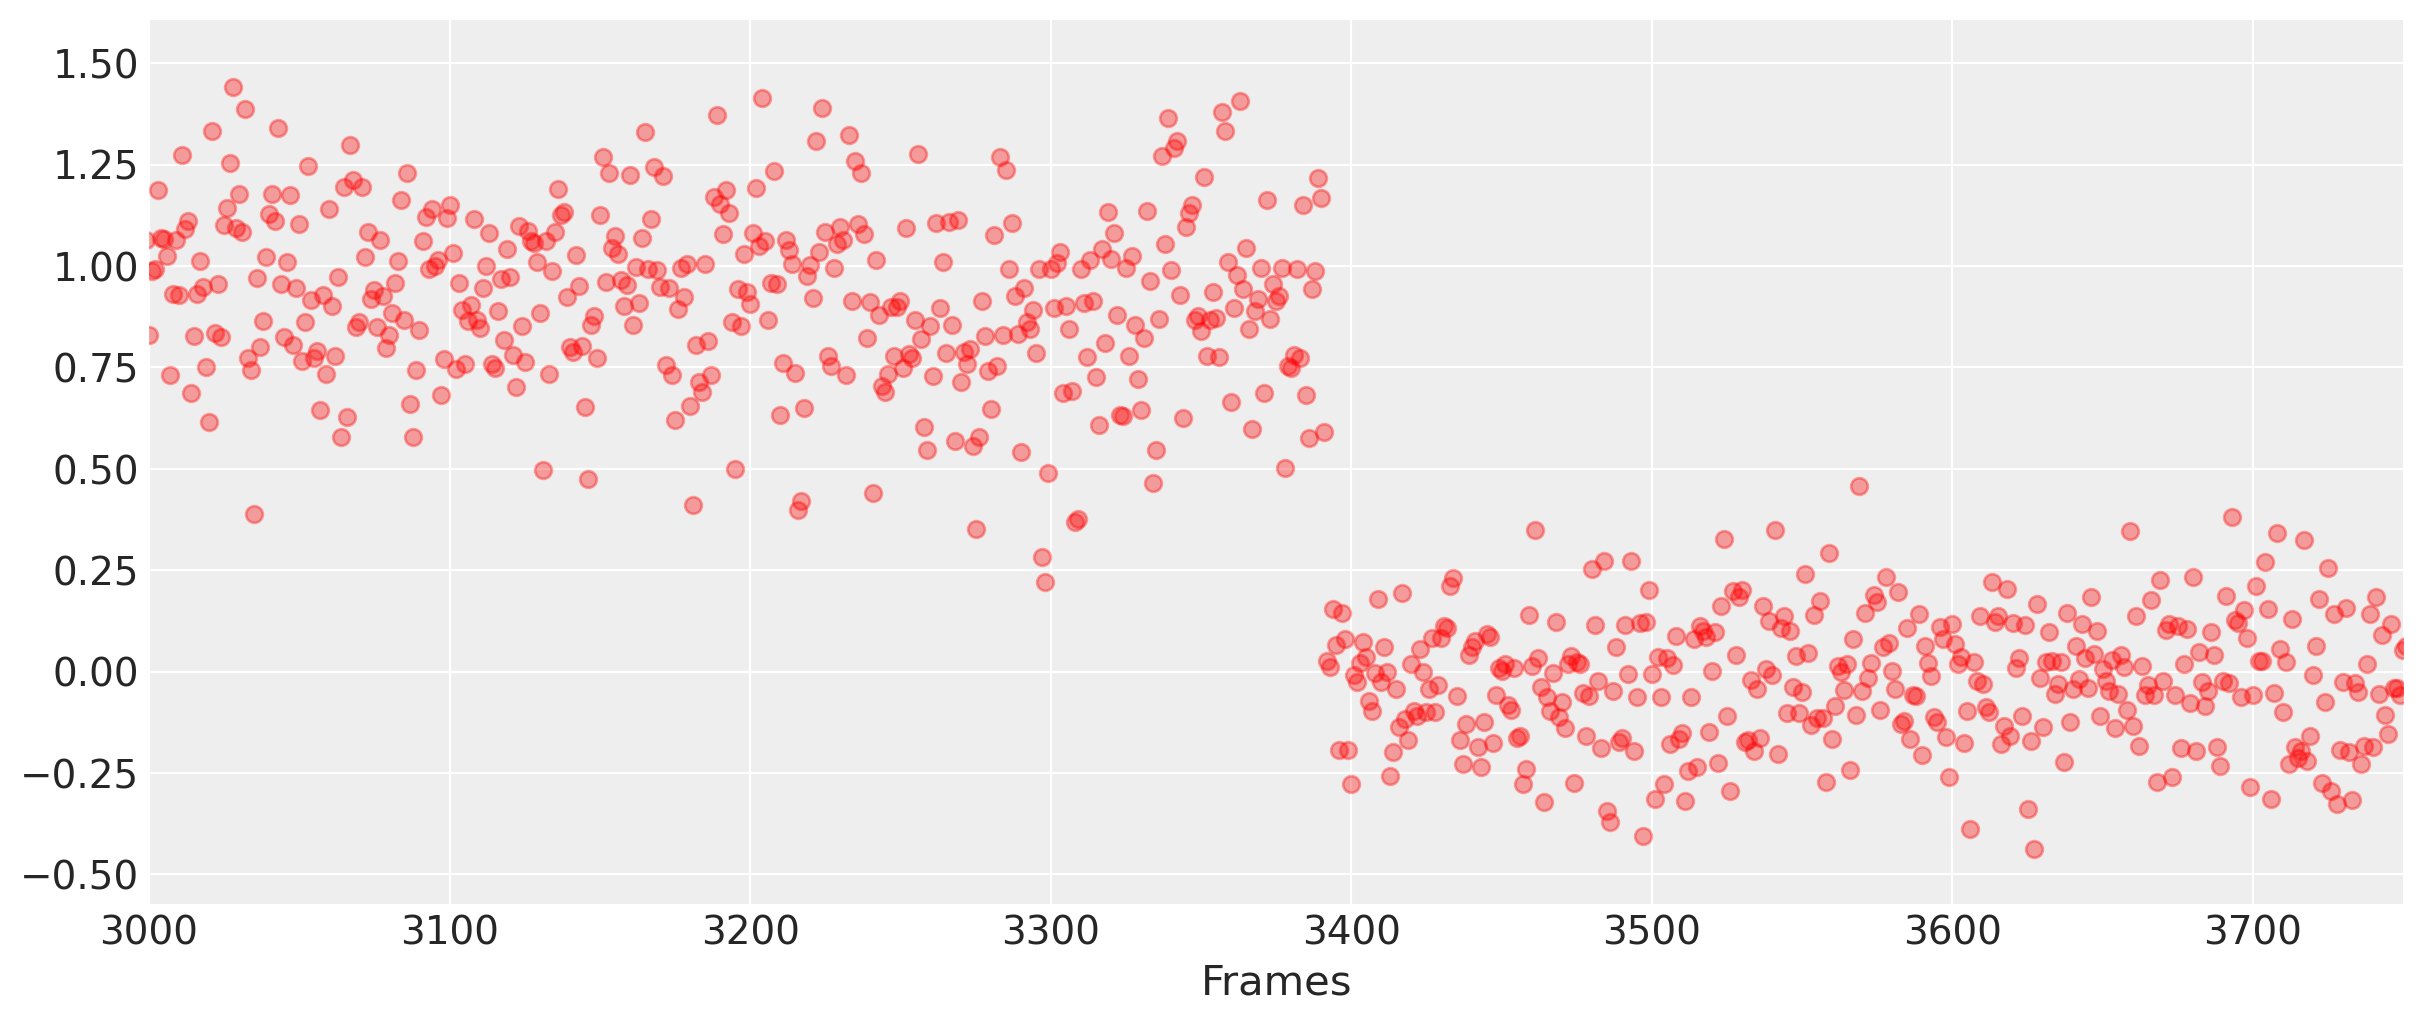

In [12]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(data_cp['Frame'], value_scaled, 'ro', alpha=0.35)
ax.set_xlabel('Frames')
ax.set_xlim(3000, 3750)

### Kurva Benda Hitam untuk HD 150366

#### Cari temperatur efektif

Temperatur efektif bintang bisa didekati dengan persamaan yang menghubungkan indeks warna bintang, $B - V$ dengan temperatur efektif bintang, $T_\mathrm{eff}$. Persamaan yang digunakan dalam pekerjaan ini diadopsi dari pekerjaan **Ballesteros 2012** (https://arxiv.org/pdf/1201.1809.pdf) sebagai berikut:

$$
T_\mathrm{eff} =  4600\left(\frac{1}{0.92 (B-V) + 1.7} + \frac{1}{0.92 (B-V) + 0.62} \right)
$$

In [13]:
# Satuan t_eff adalah Kelvin

def ballesteros(bv):
    return 4600. * ((1./(0.92*bv + 1.7)) + (1./(0.92*bv + 0.62)))

In [14]:
b = 9.805999755859375
v = 8.491000175476074

bv = b - v

teff = ballesteros(bv)
teff

4094.8013536428316

In [15]:
def Planck(λ, T): 
    """
    λ: dalam cm
    T: dalam K
    """
    a = 3.7412e-5 / ((λ * 1e-7) **5) # 1e-7 adalah konversi dari nm ke cm
    b = np.exp(1.43879/(λ * 1e-7 * T)) - 1
    return a/b

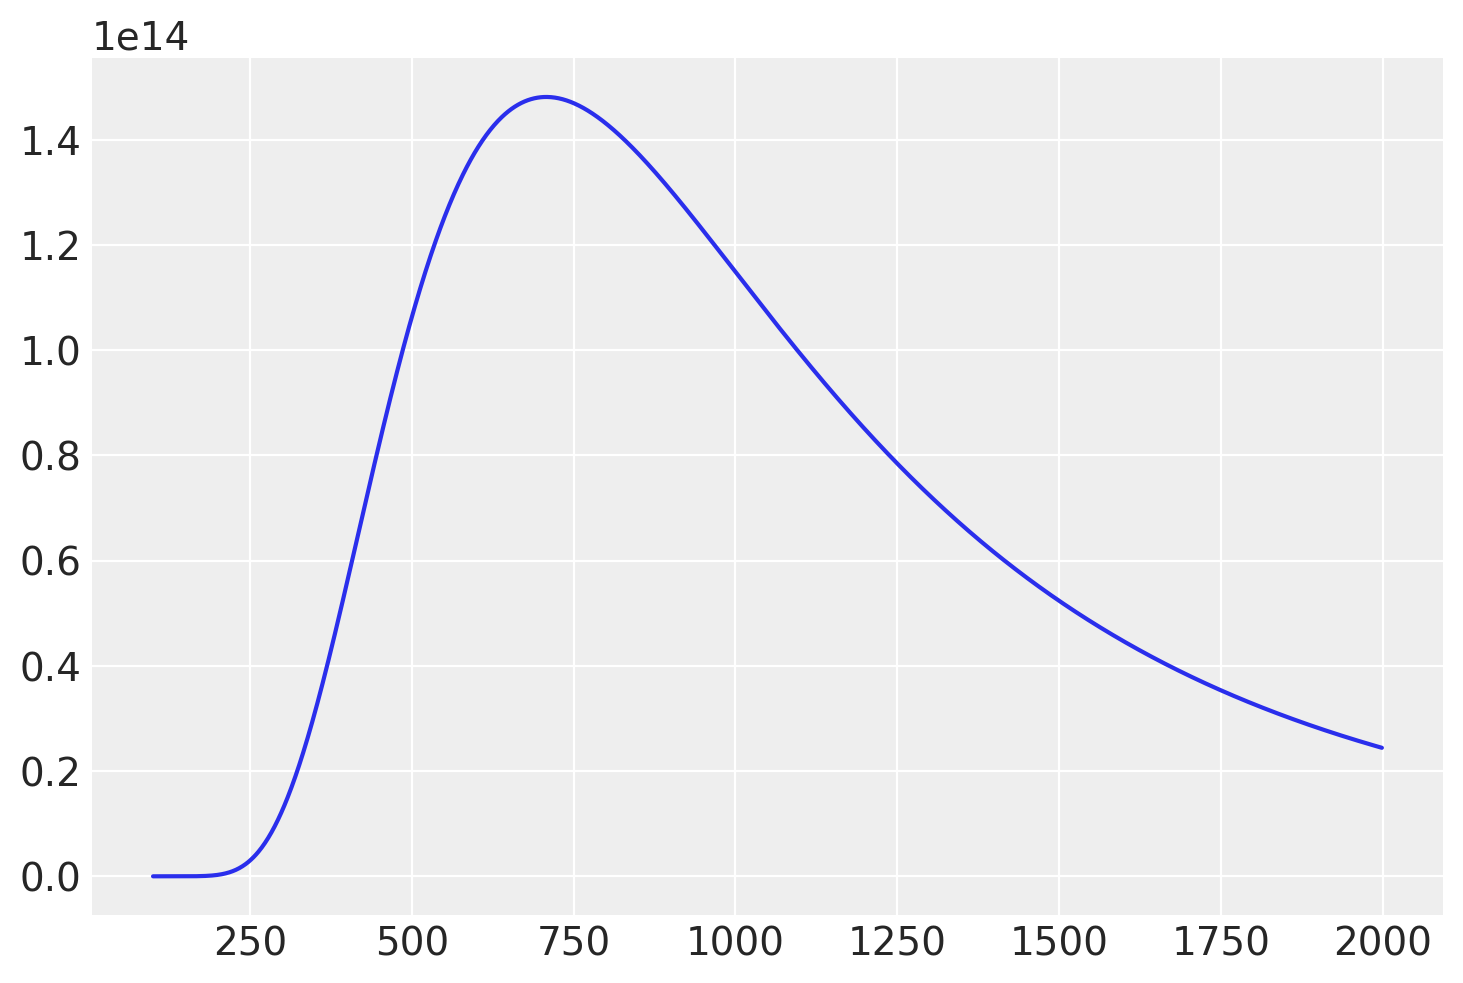

In [16]:
x_axis = np.arange(100, 2000)
y_axis = Planck(x_axis, teff)
plt.plot(x_axis, y_axis)

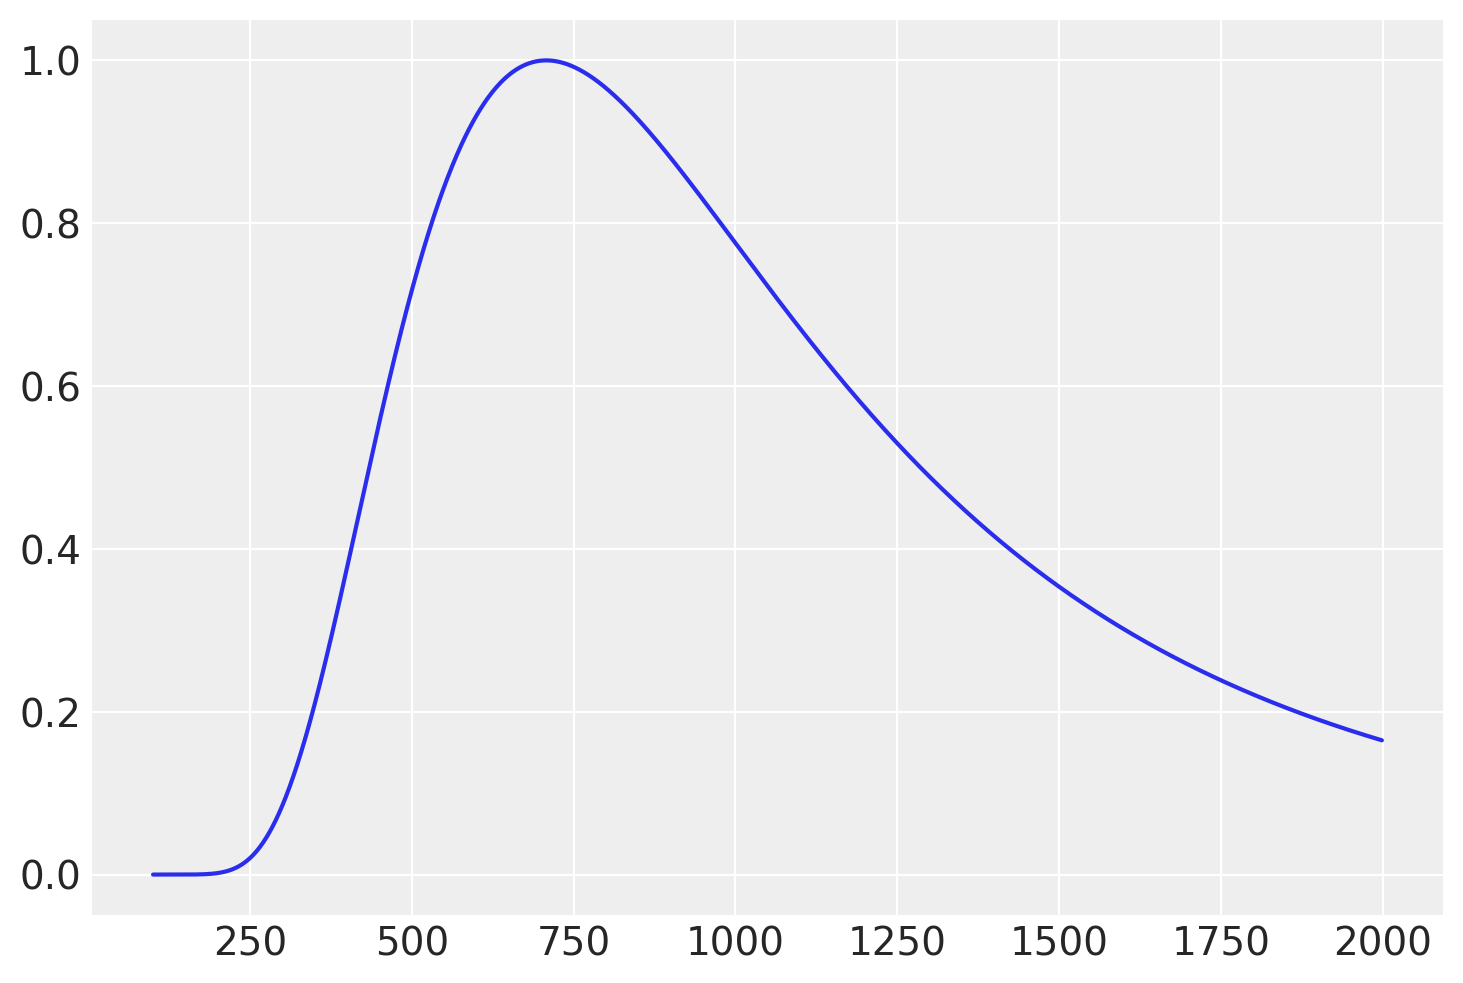

In [17]:
den = np.max(y_axis)

y_val = y_axis/den

plt.plot(x_axis, y_val)

### Kurva transmisi QHY 174M GPS *unfiltered*

In [18]:
df = pd.read_csv('qhy174_response.csv', delimiter=',', header='infer')
df.head()

wavelength  response
0       200.0       0.0
1       210.0       0.0
2       220.0       0.0
3       230.0       0.0
4       240.0       0.0

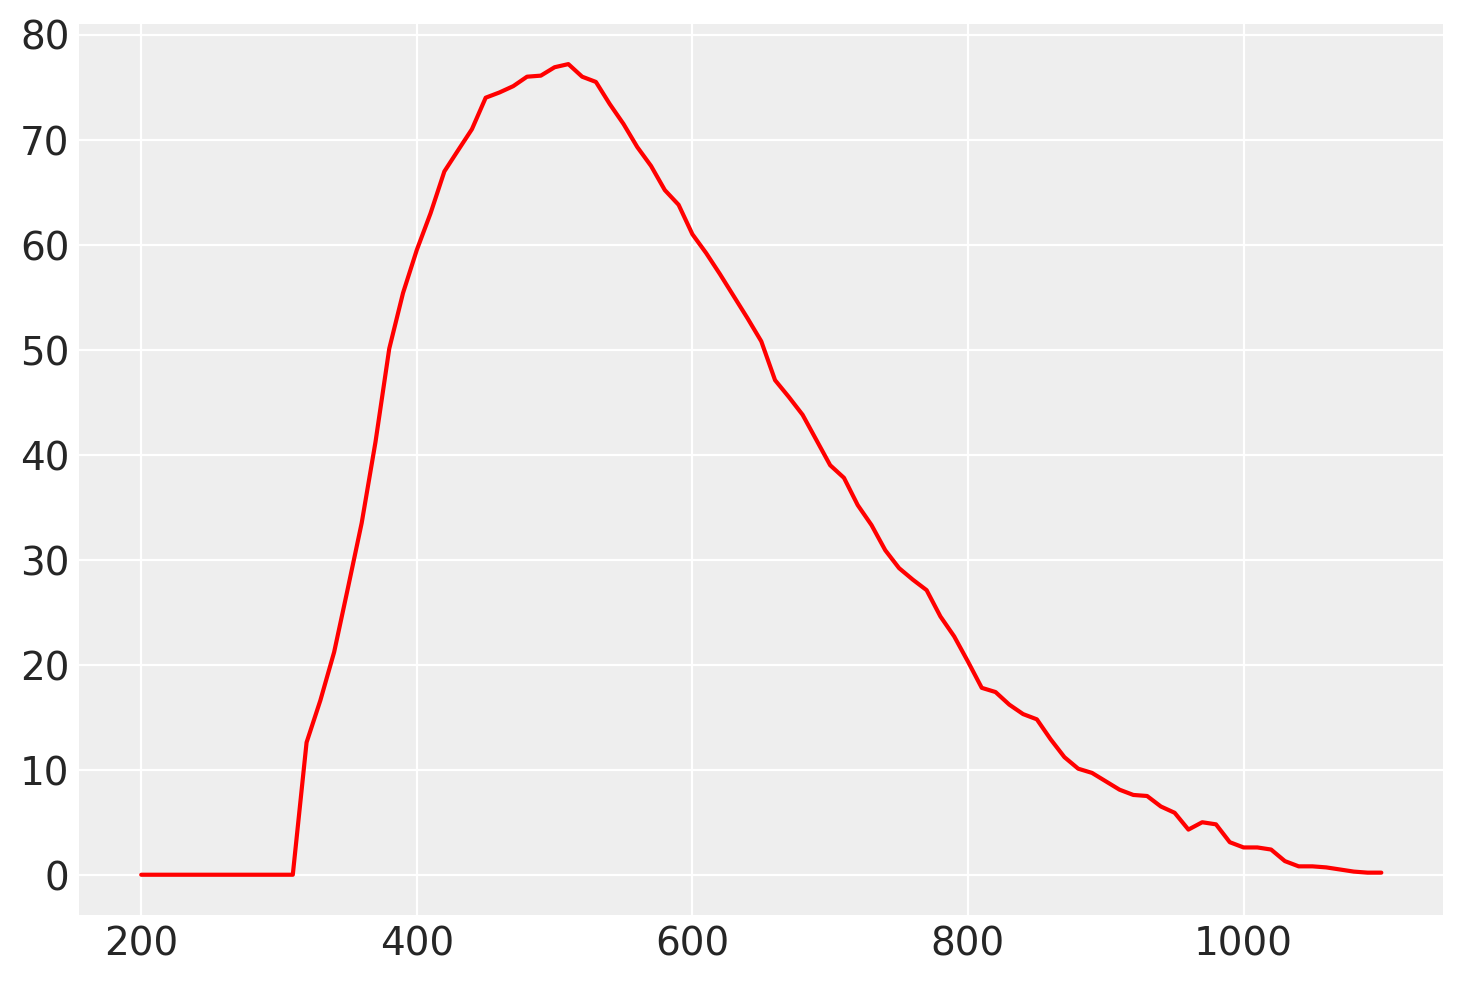

In [19]:
x = df['wavelength']
y = df['response']
plt.plot(x, y, 'r')

In [20]:
bandwidth = np.arange(330, 1100, 50) # rentang sesuai kurva transmisi
f_interp = interp1d(x, y, kind='cubic')
# bandwidth

### Jarak Bulan saat pengamatan

Pengamatan dilakukan pada tanggal **7 Agustus 2022 pukul 14:31:38.6 UT**. Ephemeris diambil dari https://ssd.jpl.nasa.gov/ftp/eph/planets/ascii/

In [21]:
# load timescale dan tampilkan waktu saat ini
ts = load.timescale()

# custom waktu untuk yyyy, mm, dd, hh, mm, ss
t = ts.utc(2022, 8, 7, 14, 31, 38.6)

In [22]:
# Load the JPL ephemeris DE430 (covers 1549-2650) dan cari jarak Bumi-Bulan
planets = load('de430.bsp')
earth, moon = planets['earth'], planets['moon']

In [23]:
# posisi Bulan dari Bumi
astrometric = earth.at(t).observe(moon)
ra, dec, distance = astrometric.radec()

In [24]:
# tampilkan koordinat Bulan dan jarak Bulan dalam AU
print(ra)
print(dec)
print(distance.km)

16h 43m 29.25s
-24deg 23' 14.2"
367071.60248704534


In [25]:
d_moon = distance.km
d_moon

367071.60248704534

## Inisiasi model

In [26]:
x_data = np.array(data_cp['Frame'])
y_data = np.array(data_cp['Value'])
# y_data = np.array(value_scaled)

In [27]:
def fresnel_polikromatik(x, x0, d, A):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = (x - x0) * np.sqrt(2 / (bandwidth[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        # model untuk disappearance
        cc, ss = sc.fresnel(-w)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y_new = f_interp(bandwidth[i]) * (Planck(bandwidth[i], T)/den) * y
        # y_new = f_interp(bandwidth[i]) * y
        y0 += y_new
    return y0

In [28]:
# Variabel benar
# -------------
x0_true = 3390
A_true = 1.
σ_true = 50.
T = teff

In [29]:
y_syn = fresnel_polikromatik(x_data, x0_true, d_moon, A_true)
y_syn = np.random.normal(y_syn, scale=σ_true)

y_syn_scaled = y_syn / (y_syn.std()*2)

Text(0, 0.5, 'Intensity')

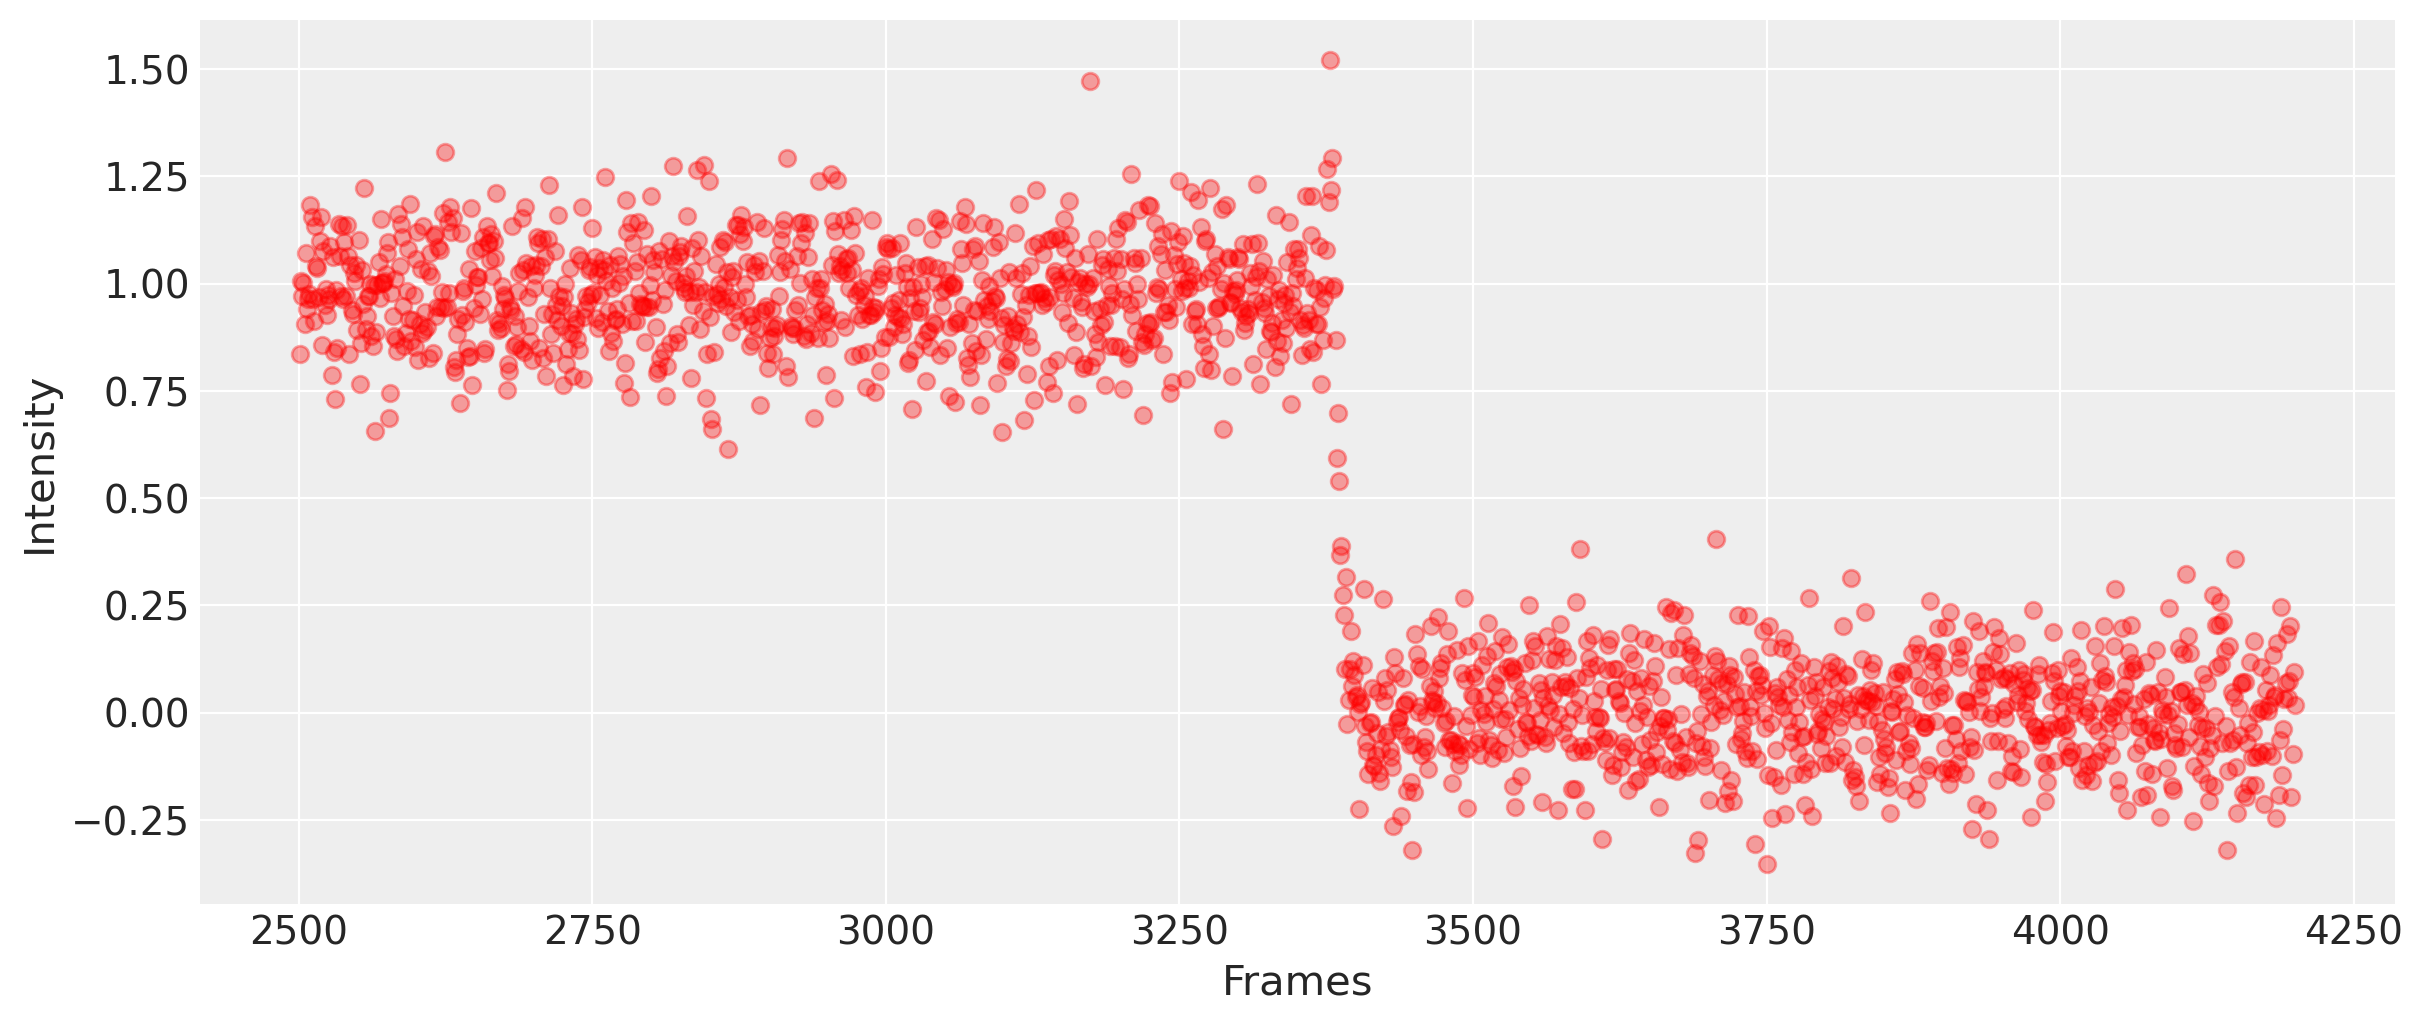

In [30]:
plt.figure(figsize = (12,5), facecolor='w')
plt.scatter(x_data, y_syn_scaled, marker='o', c='r', alpha=0.35)
# plt.invert_yaxis()
# plt.xlim(6800, 7200)
plt.xlabel('Frames')
plt.ylabel('Intensity')

In [31]:
@as_op(itypes=[at.dvector, at.dscalar, at.dscalar, at.dscalar], otypes=[at.dvector])
def t_fresnel_polikromatik(x, x0, d, A):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = (x - x0) * np.sqrt(2 / (bandwidth[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        cc, ss = sc.fresnel(-w)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y_new = f_interp(bandwidth[i]) * (Planck(bandwidth[i], T)/den) * y
        y0 += y_new
    return y0

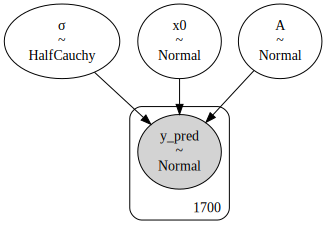

In [51]:
x_shared = aesara.shared(x_data)
d_shared = aesara.shared(d_moon)

with pm.Model() as model_polikromatik:
    A = pm.Normal('A', mu=1., sigma=20.)
    σ = pm.HalfCauchy('σ', beta=20.)
    x0 = pm.Normal('x0', mu=3390., sigma=20.)
    
    μ = t_fresnel_polikromatik(x_shared, x0, d_shared, A)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=σ, observed=value_scaled)
    
pm.model_to_graphviz(model_polikromatik)

In [52]:
with model_polikromatik:
    idata = pm.sample(cores=1)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Slice: [A]
>>Slice: [x0]
>NUTS: [σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 319 seconds.


array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'x0'}>,
        <AxesSubplot:title={'center':'x0'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

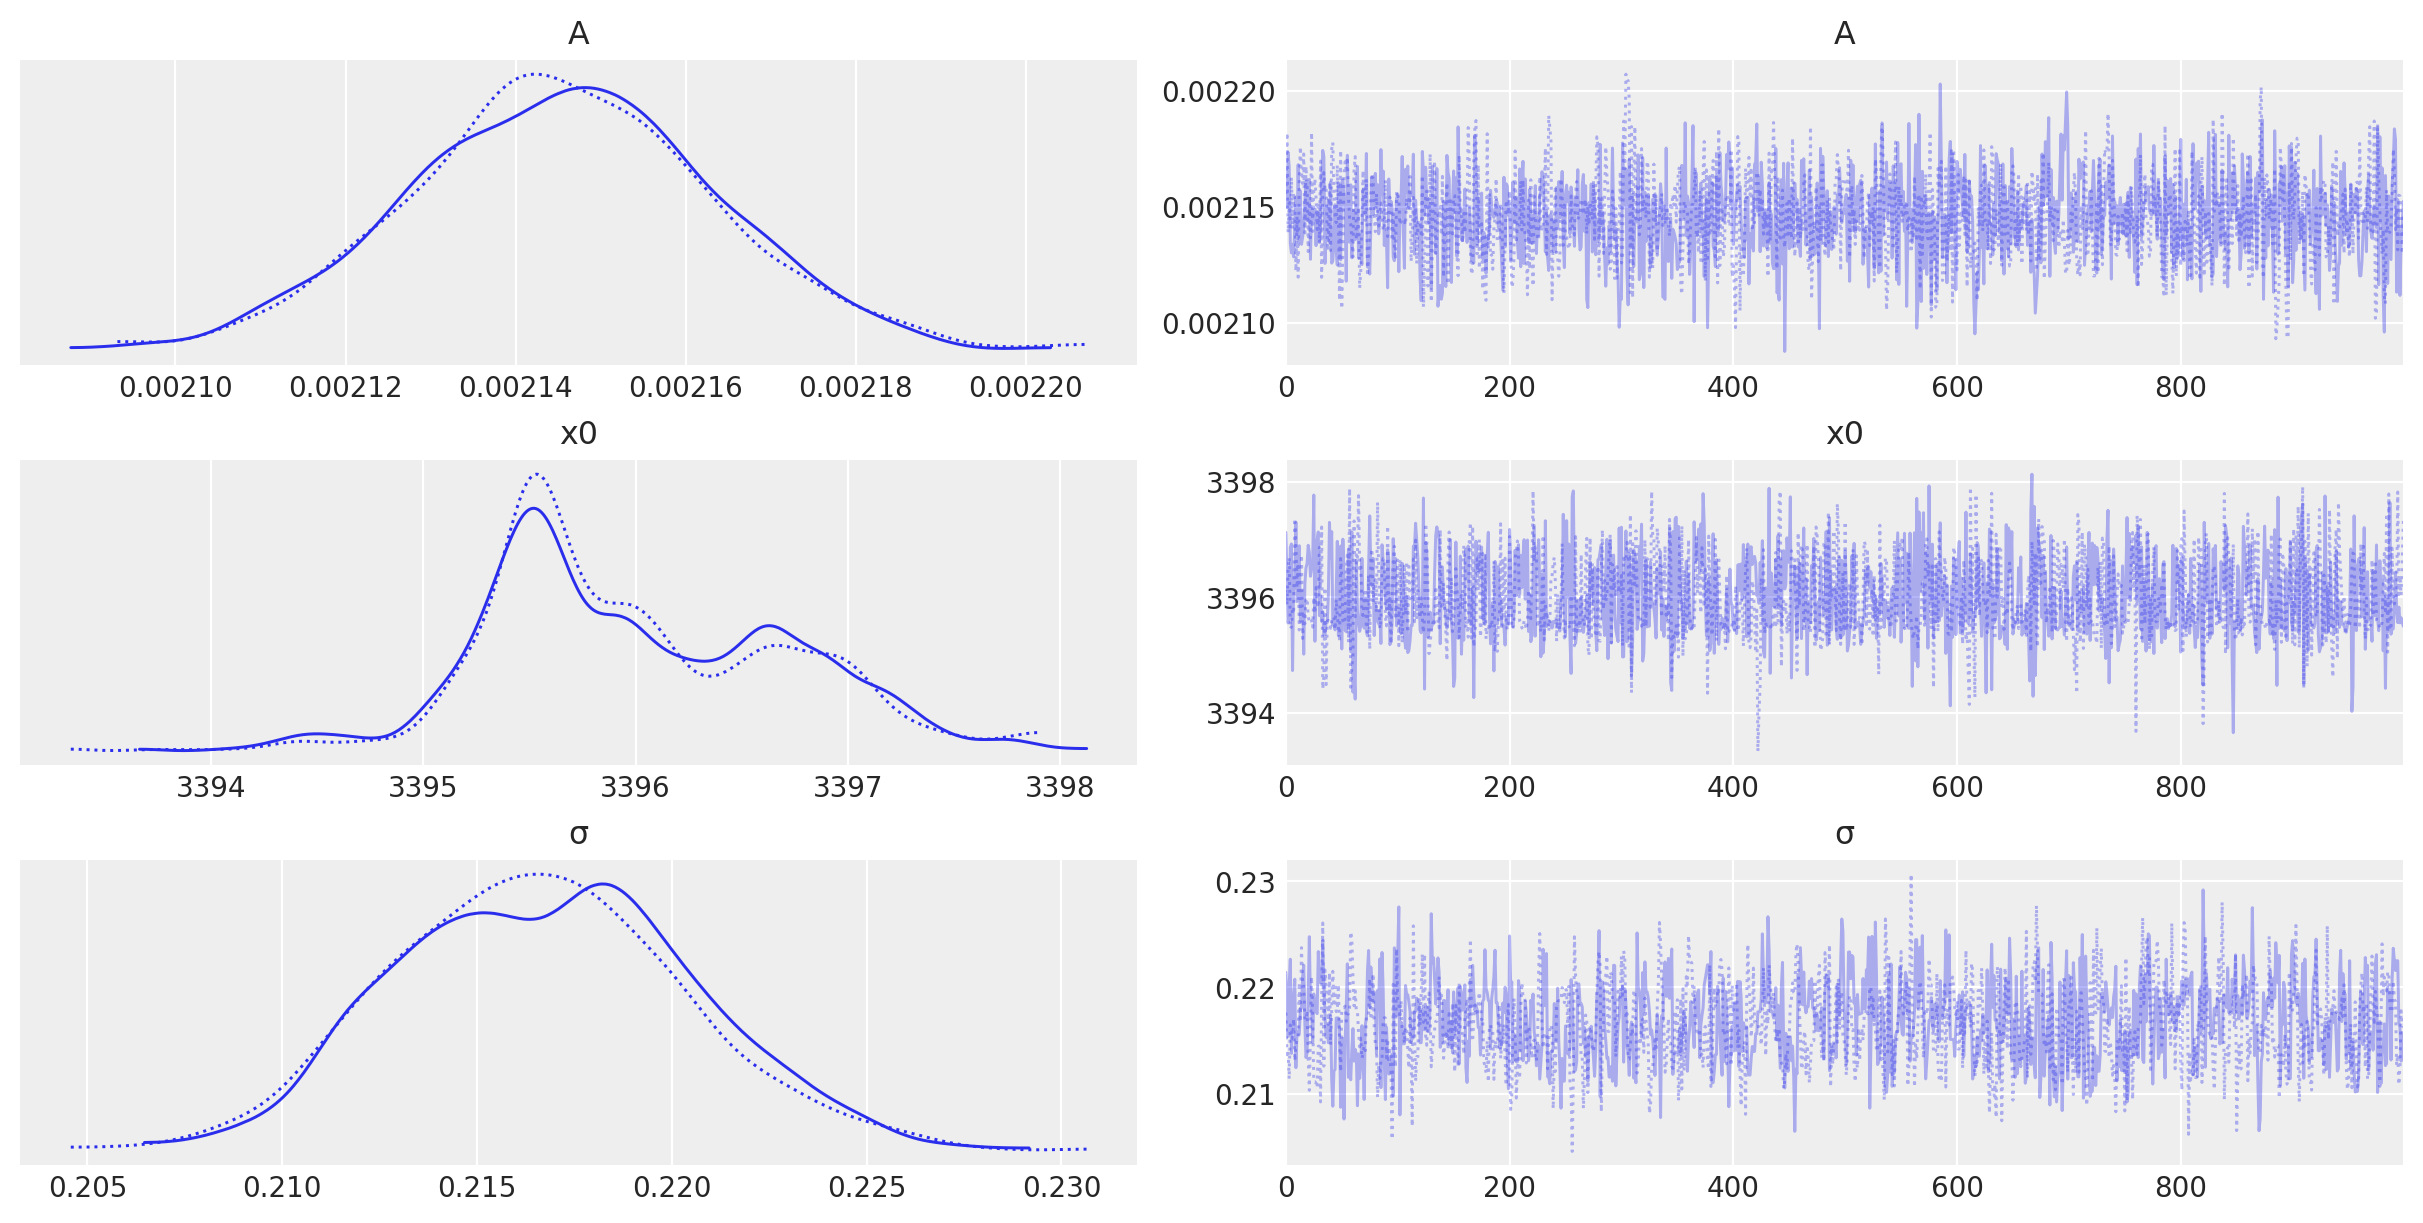

In [53]:
az.plot_trace(idata)

In [54]:
az.summary(idata)

mean    sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
A     0.002   0.0    0.002    0.002        0.0      0.0    1751.0    1154.0   
x0 3395.994 0.703 3394.965 3397.376      0.017    0.012    1836.0    1303.0   
σ     0.217 0.004     0.21    0.224        0.0      0.0     816.0    1540.0   

    r_hat  
A     1.0  
x0    1.0  
σ     1.0

In [55]:
idata_pp = idata.posterior_predictive

idata_pp_st = idata_pp.stack(sample=("chain", "draw"))

crit_l = np.percentile(idata_pp_st['y_pred'], 2.5, axis=1)  # 2.5% persentil 
crit_u = np.percentile(idata_pp_st['y_pred'], 97.5, axis=1)  # 97.5% persentil
mean_spp = np.mean(idata_pp_st['y_pred'], axis=1) # Median

C:\Users\User\AppData\Local\Temp\ipykernel_5364\2617221796.py:9: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


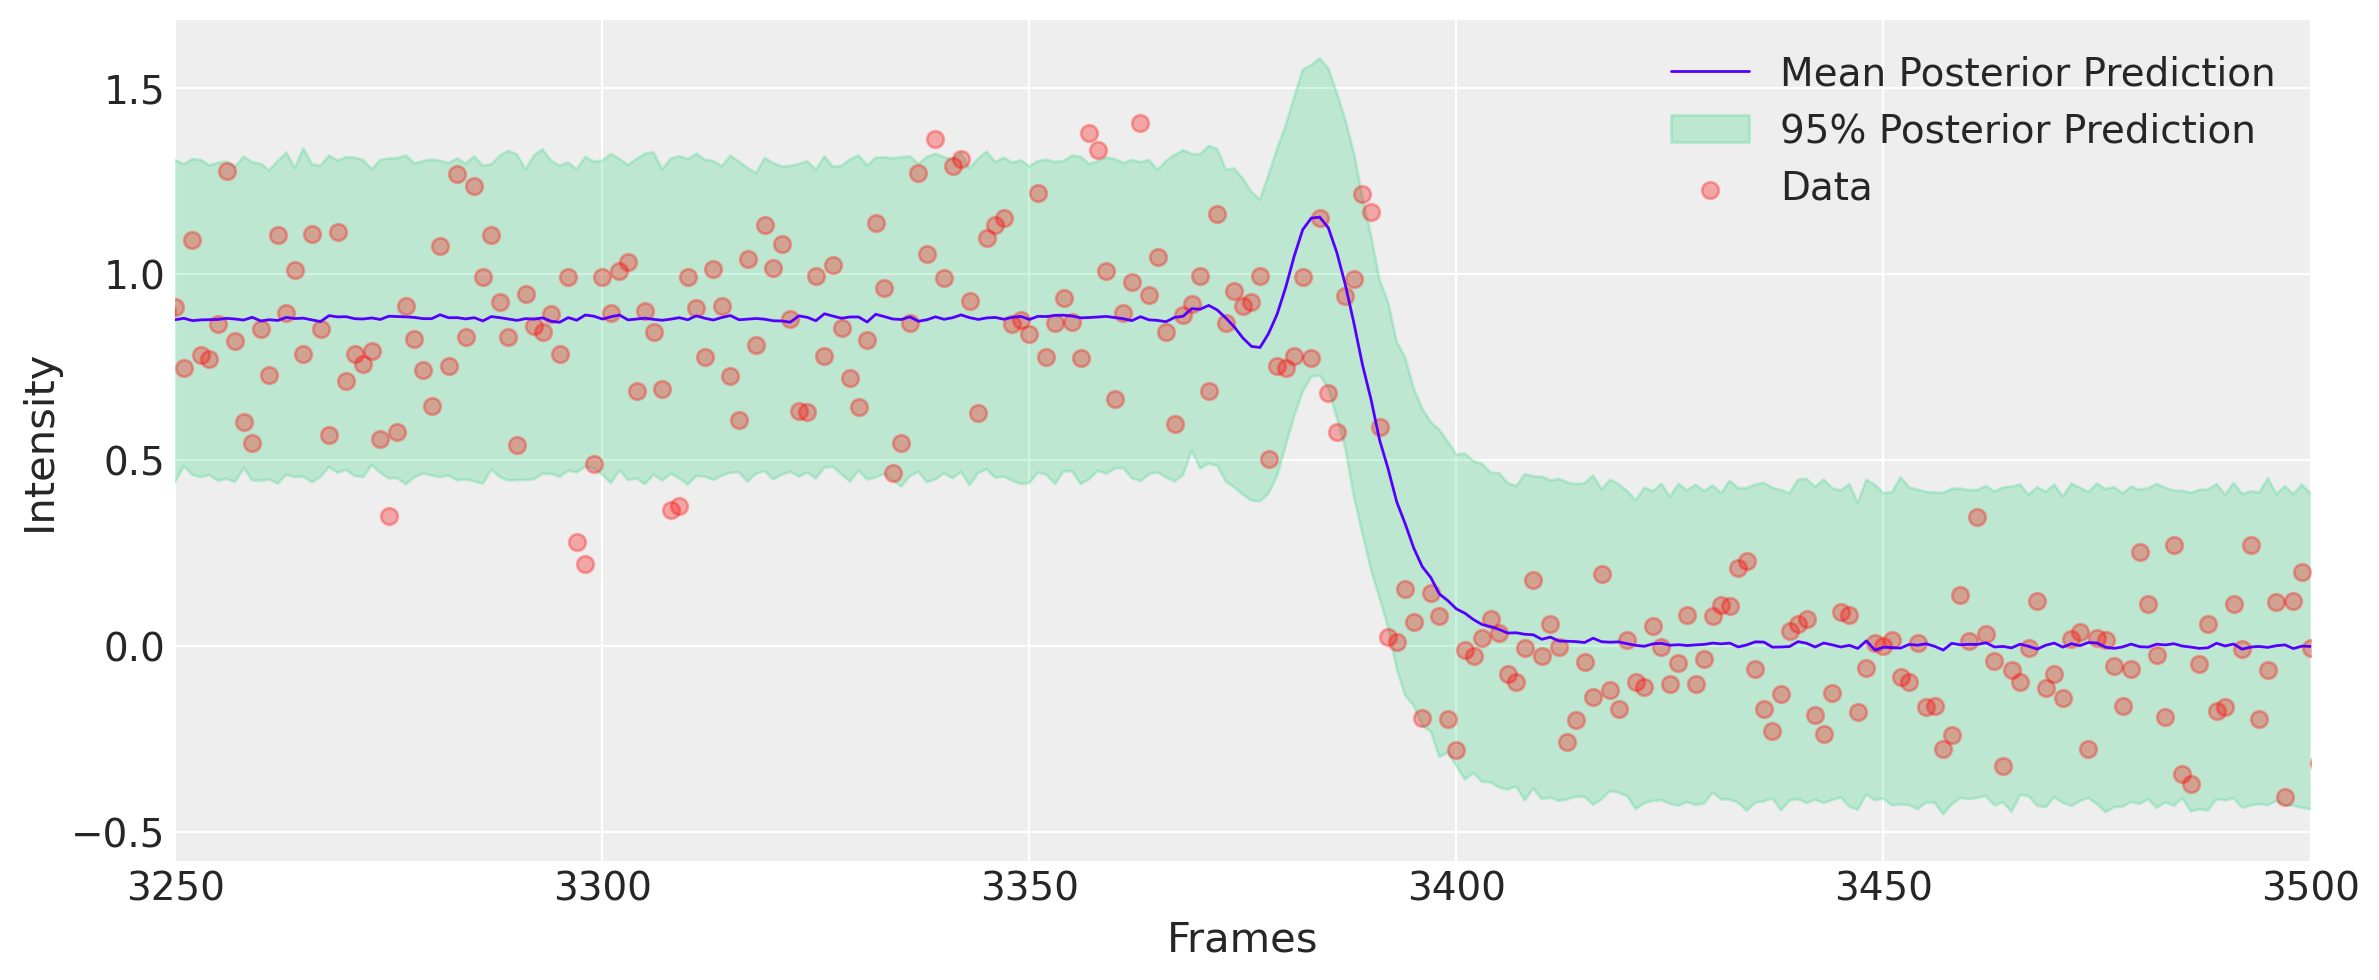

In [56]:
plt.figure(figsize=(12,5))
plt.plot(x_data, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
plt.fill_between(x_data, crit_l, crit_u, alpha=0.2, color="#00cc66")
plt.scatter(x_data, value_scaled, c='r', marker='o', alpha=0.3)
# plt.plot(x_data, y_data, 'r-', lw=1, alpha=0.5)
plt.xlabel('Frames')
plt.xlim(3250, 3500)
plt.ylabel('Intensity')
plt.tight_layout()
plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Data'], loc='upper right')

### Konversi *Frame Number* ke waktu

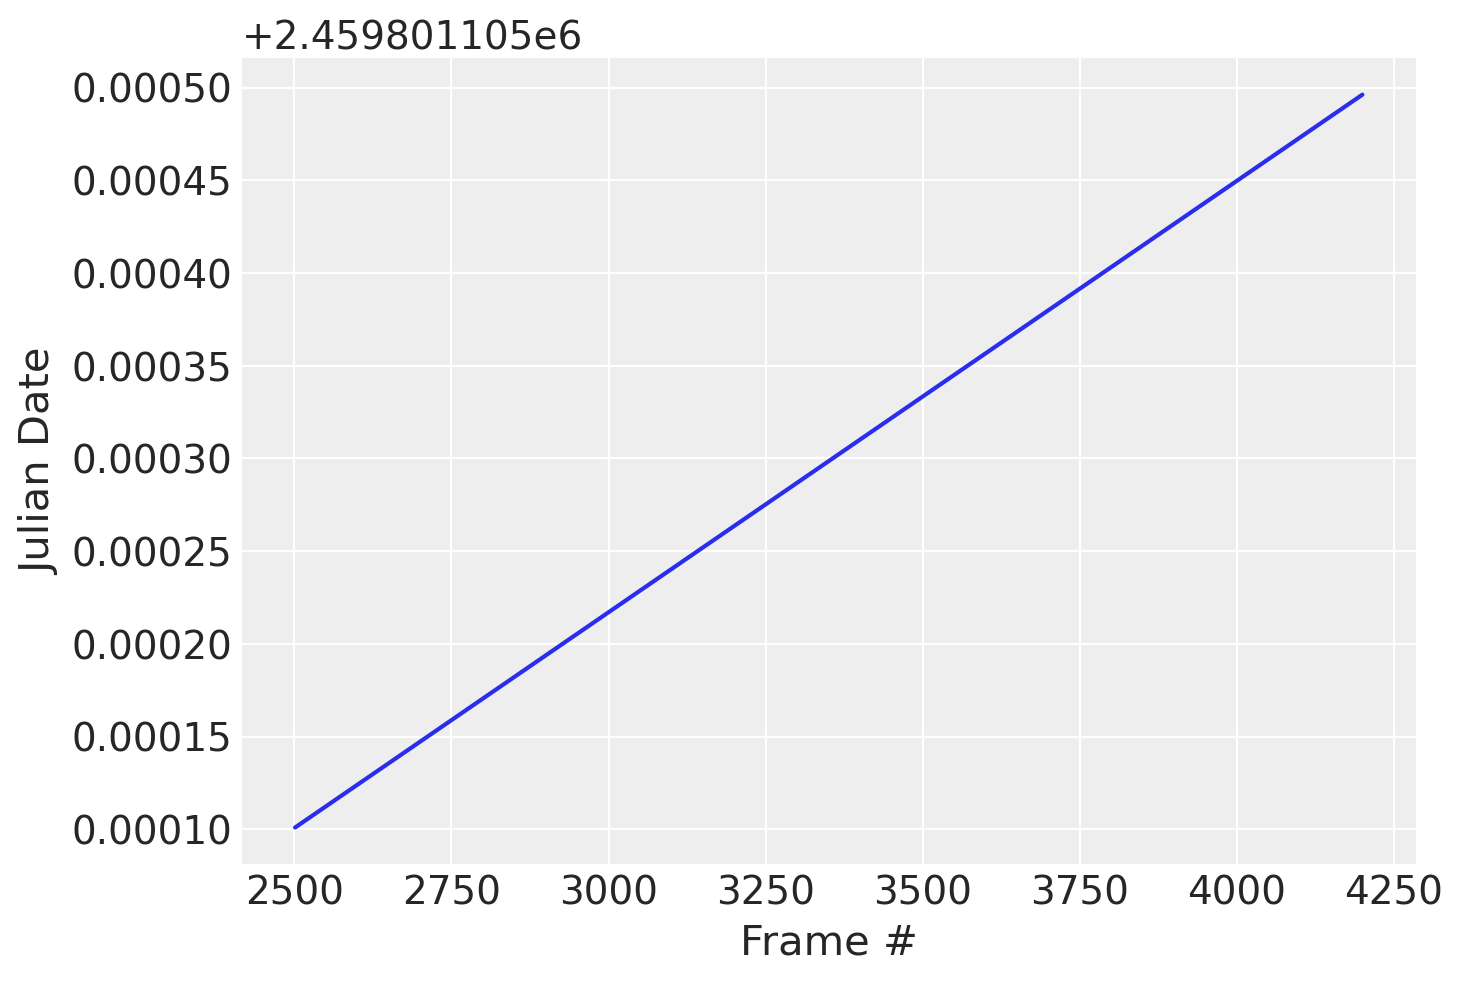

In [57]:
x = data_cp['Frame']
y = data_cp['JD']

plt.plot(x, y)
plt.xlabel('Frame #')
plt.ylabel('Julian Date')

f = interp1d(x, y, kind='cubic')

In [58]:
framenum = idata.posterior.mean().x0.values

# interpolasi

date = f(framenum)
type(date)

date_str = np.array_str(date)
date_str

# Ubah ke format waktu

j_date = Time(date_str, format='jd')
# j_date.value
iso_time = j_date.iso
iso_time

t_iso_time = pd.to_datetime(iso_time)
t_iso_time.time()

datetime.time(14, 31, 38, 712000)

In [59]:
data_cp

Frame                       Date   Value                 JD  \
0    2501.0 2022-08-09 14:31:20.726998 59845.0  2459801.105101007   
1    2502.0 2022-08-09 14:31:20.747093 45838.0 2459801.1051012394   
2    2503.0 2022-08-09 14:31:20.767188 54117.0  2459801.105101472   
3    2504.0 2022-08-09 14:31:20.787284 74622.0 2459801.1051017046   
4    2505.0 2022-08-09 14:31:20.807379 49582.0 2459801.1051019374   
...     ...                        ...     ...                ...   
1695 4196.0 2022-08-09 14:31:54.788427 -9983.0 2459801.1054952363   
1696 4197.0 2022-08-09 14:31:54.808522 -3012.0  2459801.105495469   
1697 4198.0 2022-08-09 14:31:54.828618  3204.0 2459801.1054957015   
1698 4199.0 2022-08-09 14:31:54.848713 13609.0 2459801.1054959344   
1699 4200.0 2022-08-09 14:31:54.868808  1965.0 2459801.1054961667   

                 frac_JD  
0    0.10510100703686476  
1    0.10510123940184712  
2    0.10510147223249078  
3    0.10510170459747314  
4     0.1051019374281168  
...                  ...  
1695 0.10549523634836078  
1696 0.10549546917900443  
1697  0.1054957015439868  
1698 0.10549593437463045  
1699 0.10549616673961282  

[1700 rows x 5 columns]

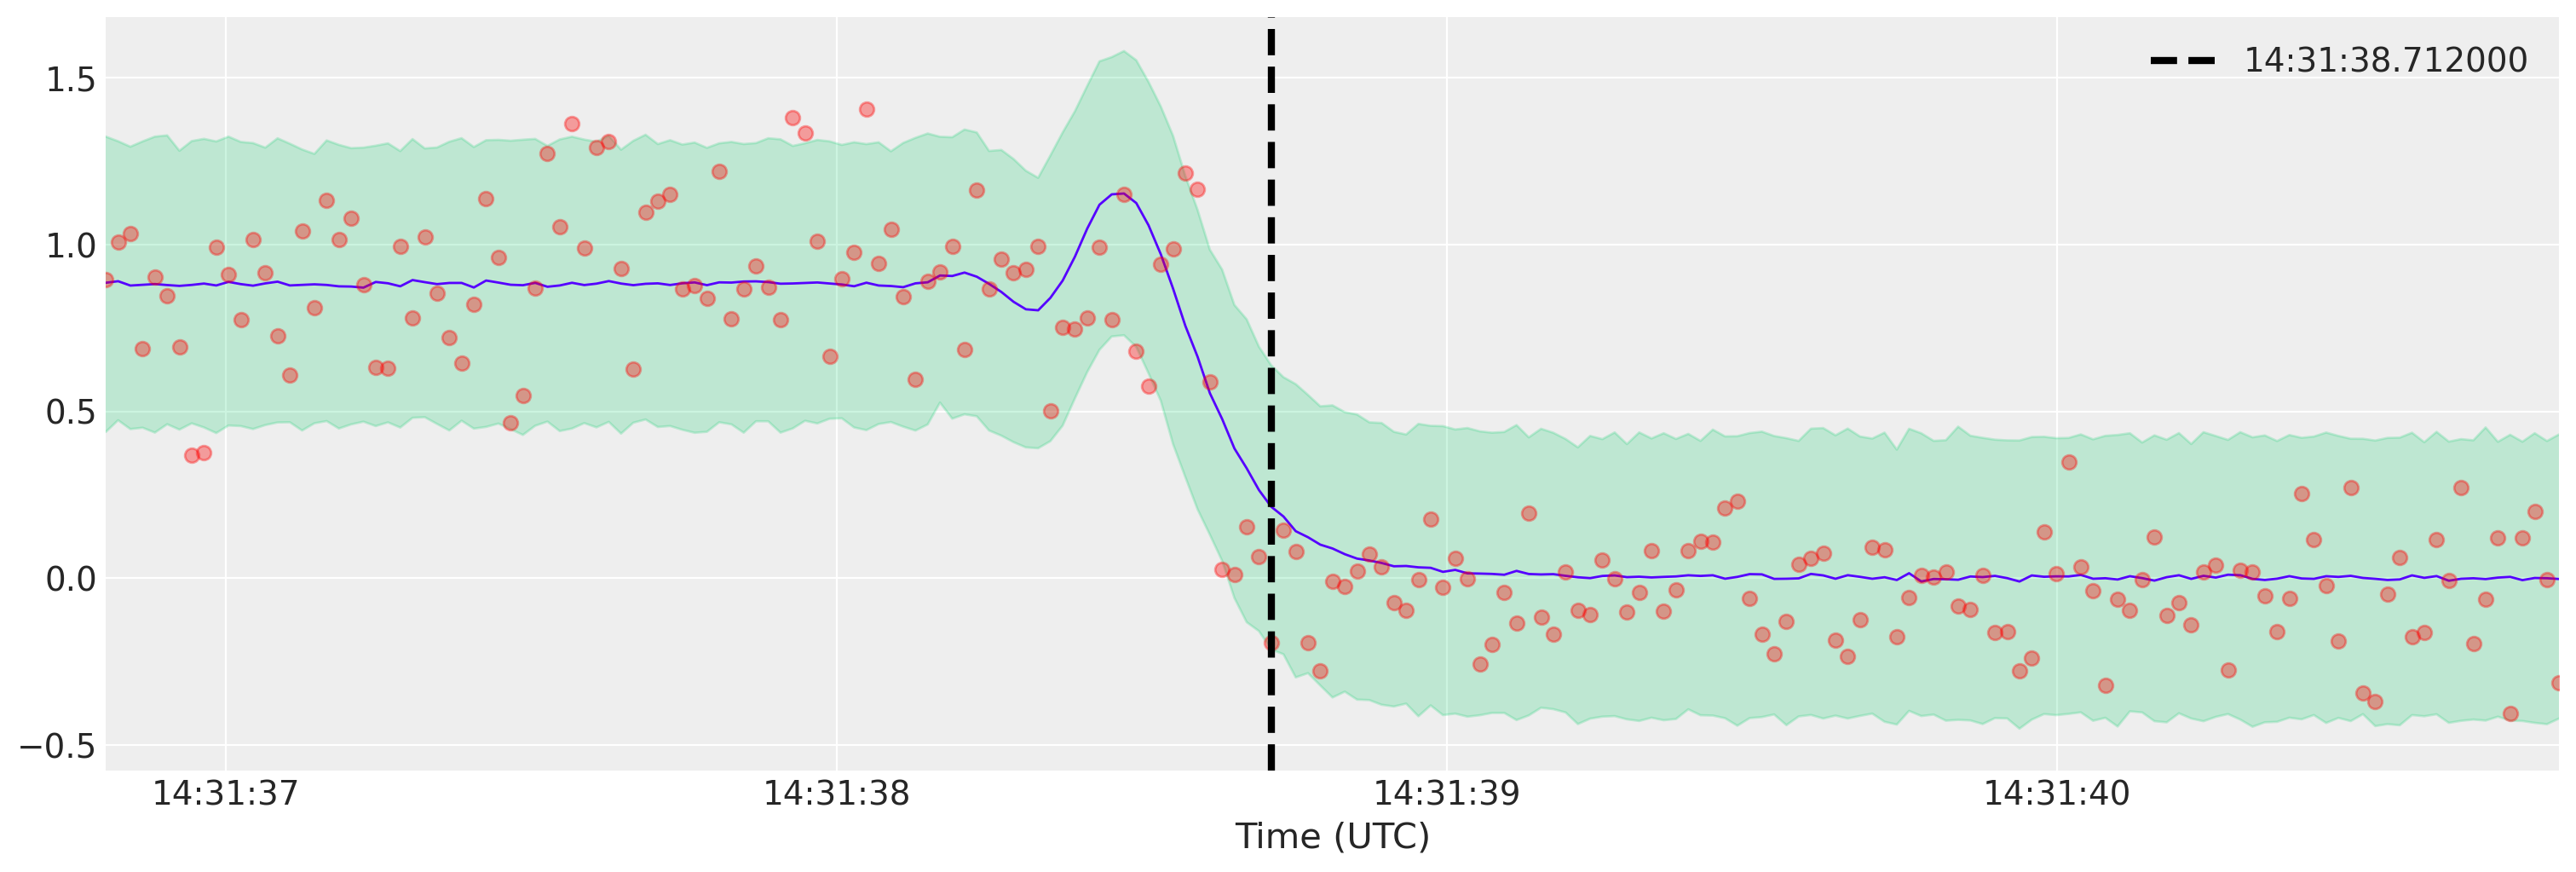

In [60]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(data_cp['Date'], mean_spp, linestyle='-', linewidth=1, color="#5500ff")
ax.fill_between(data_cp['Date'], crit_l, crit_u, alpha=0.2, color="#00cc66")
ax.plot(data_cp['Date'], value_scaled, 'ro', alpha=0.35)
# ax.plot(data['Time'], y_filtered, 'ro', alpha=0.35)

plt.axvline(x = t_iso_time, color = 'k', lw=3, ls='--', label = t_iso_time.time())
plt.legend(loc = 'upper right')

#ax.plot(data['Frame'], data['Value'], 'ro', alpha=0.35)
# ax.set_xlabel('UTC (mm:ss.ssssss)')
ax.set_xlim(data_cp['Date'][800], data_cp['Date'][1000]) # baris ke-# untuk kolom 'Time'
ax.set_xlabel('Time (UTC)')

date_form = mdates.DateFormatter("%H:%M:%S")#, tz=pytz.timezone(‘Australia/Sydney’))
#ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
#ax.xaxis.set_major_locator(mdates.HourLocator(byhour=None, interval=2))
ax.xaxis.set_major_formatter(date_form)
# ax.tick_params('x', labelrotation=45)

# data['Time'].dt.hour()

<AxesSubplot:xlabel='y_pred / y_pred'>

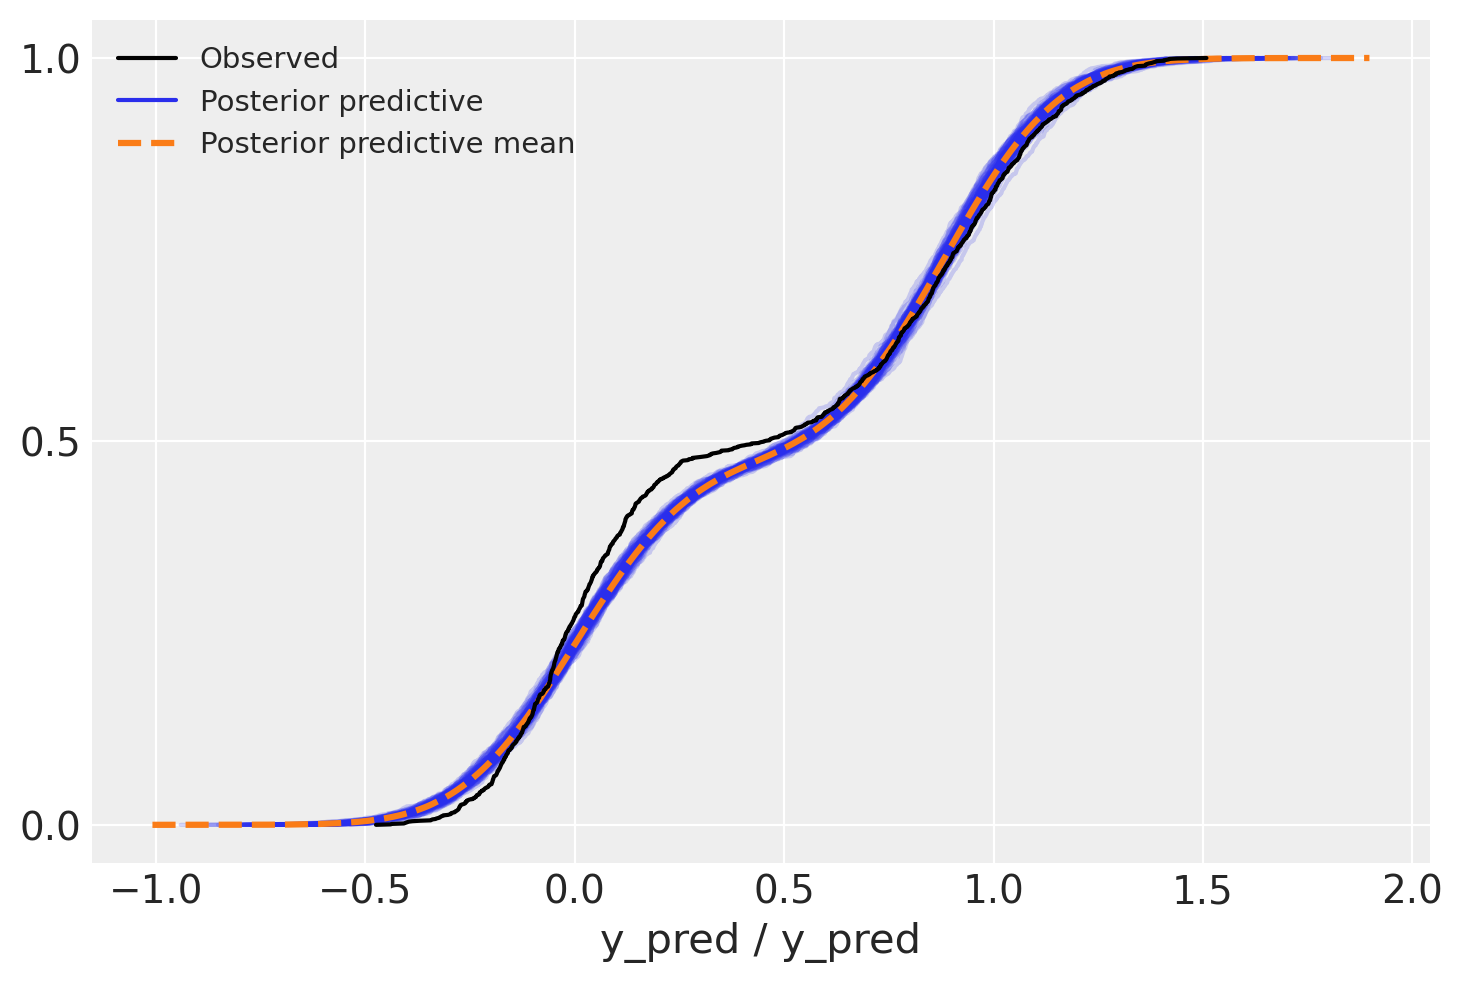

In [61]:
az.plot_ppc(idata, num_pp_samples=100, kind='cumulative')